# Jet response

This script generates figure 2: jet shift vs. jet strengthening over the North Atlantic and over Europe for
- coupled CMIP5 models (RCP8.5)
- atmosphere CMIP5 models (amipFuture and amip4K)
- ICON, MPI-ESM and IPSL-CM5A.

Note: for ICON, we investigate simulations with locked clouds and interactive water vapor. For MPI-ESM and IPSL-CM5A, we investigate simulations with both locked clouds and locked water vapor.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# inset small plot in large plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.mpl.geoaxes

import helper_functions as fct

### Specify months and seasons of the year

In [2]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

### Specify CMIP5 models and simulations that are analyzed

In [3]:
# models
models_amip = ['bcc-csm1-1', 'CanAM4', 'CCSM4', 'CNRM-CM5', 'HadGEM2-A',
               'IPSL-CM5A-LR', 'IPSL-CM5B-LR', 'MIROC5', 'MPI-ESM-LR',
               'MPI-ESM-MR', 'MRI-CGCM3']
models_cmip = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1-m', 'bcc-csm1-1',
               'BNU-ESM', 'CanESM2', 'CCSM4', 'CESM1-BGC',
               'CESM1-CAM5', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS',
               'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2',
               'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M',
               'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC',
               'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR',
               'IPSL-CM5B-LR', 'MIROC5', 'MIROC-ESM-CHEM', 'MIROC-ESM',
               'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-ME',
               'NorESM1-M']

# simulations
sims_cmip = ['historical', 'rcp85']
sims_amip = ['amip', 'amip4K', 'amipFuture']

### Read data (ICON, MPI-ESM, IPSL-CM5A)

In [4]:
# ICON simulations with locked clouds and interactive water vapor
runs_cld = ['T1C1', 'T2C2']
ipath = '../../ICON-NWP_lockedclouds/'
u850_icon = {}
for run in runs_cld:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    lats = np.array(ncfile.variables['lat'][:].data)
    lons = np.array(ncfile.variables['lon'][:].data)
    levs = np.array(ncfile.variables['lev'][:].data)
    uwind = np.array(ncfile.variables['u'][:].data)
    ncfile.close()    
    # get zonal wind at 850 hPa
    levind850 = (np.abs(levs-85000)).argmin() # find index of 850 hPa level
    u850_icon[run] = uwind[:, levind850, :, :]
    del levs, uwind, levind850
    del ifile, ncfile
del run, ipath

##############################################################################
# MPI-ESM and IPSL-CM5A simulations with locked clouds and locked water vapor
runs_cldvap = ['T1C1W1', 'T2C2W2']
u850_mpi = {}; u850_ipsl = {}
for run in runs_cldvap:
    print('reading ' + run)
    # MPI-ESM
    #print('   MPI-ESM')
    ifile = 'MPI-ESM_' + run + '_3d_mm.uwind.nc'
    u850_mpi[run], lats_mpi, lons_mpi = fct.read_var_onelevel('../../MPI-ESM/' + ifile,
                                                              'u', 'plev', 850)
    del ifile
    
    # IPSL-CM5A
    #print('   IPSL-CM5A')
    ifile = 'IPSL-CM5A_' + run + '_3d_mm.remapcon.uwind.nc'
    u850_ipsl[run], lats_ipsl, lons_ipsl = fct.read_var_onelevel('../../IPSL-CM5A/' + ifile,
                                                                 'vitu', 'presnivs', 850)
    del ifile
del run

reading T1C1
reading T2C2
reading T1C1W1
reading T2C2W2


### Read data (CMIP5 models)¶

Note: All simulations were interpolated to the same grid and stored in numpy arrays with the jupyter notebook "interpolate_cmip5_data_to_common_grid.ipynb".

In [5]:
ipath = '../../cmip5/'
ntime = 360 # length of cmip/amip simulations in months (30 years)

# coupled models: historical and RCP8.5 simulations
# create arrays with dimensions (ntime, number of models, lats, lons)
u850_hist = np.full((ntime, len(models_cmip), len(lats), len(lons)),
                    np.nan, dtype=float)
u850_rcp85 = np.full((ntime, len(models_cmip), len(lats), len(lons)),
                     np.nan, dtype=float)
for m, model in enumerate(models_cmip):
    u850_hist[:, m, :, :] = np.load(ipath + model + '_u850_historical.npy')
    u850_rcp85[:, m, :, :] = np.load(ipath + model + '_u850_rcp85.npy')
del m, model

# atmosphere models: amip, amip4K and amipFuture simulations
# create arrays with dimensions (ntime, number of models, lats, lons)
u850_amip = np.full((ntime, len(models_amip), len(lats), len(lons)),
                    np.nan, dtype=float)
u850_amip4k = np.full((ntime, len(models_amip), len(lats), len(lons)),
                      np.nan, dtype=float)
u850_amipfut = np.full((ntime, len(models_amip), len(lats), len(lons)),
                       np.nan, dtype=float)
for m, model in enumerate(models_amip):
    u850_amip[:, m, :, :] = np.load(ipath + model + '_u850_amip.npy')
    u850_amip4k[:, m, :, :] = np.load(ipath + model + '_u850_amip4k.npy')
    u850_amipfut[:, m, :, :] = np.load(ipath + model + '_u850_amipfut.npy')
del m, model
del ipath

### Calculate DJF mean for all simulations

In [6]:
# ICON
u850_icon_djf = {}
for run in runs_cld:
    u850_icon_djf[run] = fct.calcMonthlyandSeasonMean(u850_icon[run],
                                                      months, seasons)[1]['DJF']
del run

# MPI-ESM and IPSL-CM5A
u850_mpi_djf = {}; u850_ipsl_djf = {}
for run in runs_cldvap:
    u850_mpi_djf[run] = fct.calcMonthlyandSeasonMean(u850_mpi[run],
                                                     months, seasons)[1]['DJF']
    u850_ipsl_djf[run] = fct.calcMonthlyandSeasonMean(u850_ipsl[run],
                                                      months, seasons)[1]['DJF']
del run

# coupled CMIP5 models
u850_cmip_djf = np.full((len(sims_cmip), len(models_cmip), len(lats),
                         len(lons)), np.nan, dtype=float)
u850_cmip_djf[0, :, :, :] = fct.calcMonthlyandSeasonMean(u850_hist, months,
                                                         seasons)[1]['DJF']
u850_cmip_djf[1, :, :, :] = fct.calcMonthlyandSeasonMean(u850_rcp85, months,
                                                         seasons)[1]['DJF']

# atmosphere CMIP5 models
u850_amip_djf = np.full((len(sims_amip), len(models_amip), len(lats),
                         len(lons)), np.nan, dtype=float)
u850_amip_djf[0, :, :, :] = fct.calcMonthlyandSeasonMean(u850_amip, months,
                                                         seasons)[1]['DJF']
u850_amip_djf[1, :, :, :] = fct.calcMonthlyandSeasonMean(u850_amip4k, months,
                                                         seasons)[1]['DJF']
u850_amip_djf[2, :, :, :] = fct.calcMonthlyandSeasonMean(u850_amipfut, months,
                                                         seasons)[1]['DJF']

# model mean for historical and amip simulations
u850_cmip_djf_mm = np.nanmean(u850_cmip_djf, axis=1)
u850_amip_djf_mm = np.nanmean(u850_amip_djf, axis=1)

# delete variables with time information
del u850_icon, u850_mpi, u850_ipsl
del u850_hist, u850_rcp85, u850_amip, u850_amip4k, u850_amipfut

/mnt/lustre02/work/bb1018/b380490/outputdata/ERL2021_data/pythonscripts/helper_functions.py:64: RuntimeWarning: Mean of empty slice
  monthly_mean[month] = np.nanmean(monthly_data[month], axis=0)
/mnt/lustre02/work/bb1018/b380490/outputdata/ERL2021_data/pythonscripts/helper_functions.py:71: RuntimeWarning: Mean of empty slice
  seasons_dict[season] ], axis=0)


### Calculate zonal-mean u850 over the North Atlantic (60W-0E) and over Europe (0E-25E)

In [7]:
# boundaries of regions
box_west = [0, -60]
box_east = [25, 0]

# coupled models
u850_cmip_box = np.full((len(box_west), len(sims_cmip), len(models_cmip),
                         len(lats)), np.nan, dtype=float)
u850_cmip_mm_box = np.full((len(box_west), len(sims_cmip), len(lats)),
                           np.nan, dtype=float)
for b in range(len(box_west)):
    for s in range(len(sims_cmip)):
        for m in range(len(models_cmip)):
            u850_cmip_box[b, s, m, :] = fct.calcBoxZonalmean(u850_cmip_djf[s, m, :, :],
                                                             lats, lons, box_west[b], box_east[b])
        del m
        u850_cmip_mm_box[b, s, :] = fct.calcBoxZonalmean(u850_cmip_djf_mm[s, :, :],
                                                         lats, lons, box_west[b], box_east[b])
    del s
del b

# amip models
u850_amip_box = np.full((len(box_west), len(sims_amip), len(models_amip),
                         len(lats)), np.nan, dtype=float)
u850_amip_mm_box = np.full((len(box_west), len(sims_amip), len(lats)),
                           np.nan, dtype=float)
for b in range(len(box_west)):
    for s in range(len(sims_amip)):
        for m in range(len(models_amip)):
            u850_amip_box[b, s, m, :] = fct.calcBoxZonalmean(u850_amip_djf[s, m, :, :],
                                                             lats, lons,
                                                             box_west[b], box_east[b])
        del m
        u850_amip_mm_box[b, s, :] = fct.calcBoxZonalmean(u850_amip_djf_mm[s, :, :],
                                                         lats, lons,
                                                         box_west[b], box_east[b])
    del s
del b

# ICON
u850_icon_box = {}
for run in runs_cld:
    u850icon = np.full((len(box_west), len(lats)), np.nan, dtype=float)
    for b in range(len(box_west)):
        u850icon[b, :] = fct.calcBoxZonalmean(u850_icon_djf[run],
                                              lats, lons,
                                              box_west[b], box_east[b])
    u850_icon_box[run] = u850icon.copy()
    del u850icon, b
del run

# MPI-ESM, IPSL-CM5A
u850_mpi_box = {}; u850_ipsl_box = {}
for run in runs_cldvap:
    u850mpi = np.full((len(box_west), len(lats)), np.nan, dtype=float)
    u850ipsl = np.full((len(box_west), len(lats)), np.nan, dtype=float)
    for b in range(len(box_west)):
        u850mpi[b, :] = fct.calcBoxZonalmean(u850_mpi_djf[run],
                                             lats_mpi, lons_mpi,
                                             box_west[b], box_east[b])
        u850ipsl[b, :] = fct.calcBoxZonalmean(u850_ipsl_djf[run],
                                              lats, lons,
                                              box_west[b], box_east[b])
    u850_mpi_box[run] = u850mpi.copy()
    u850_ipsl_box[run] = u850ipsl.copy()
    del u850mpi, u850ipsl, b
del run

/mnt/lustre02/work/bb1018/b380490/outputdata/ERL2021_data/pythonscripts/helper_functions.py:354: RuntimeWarning: Mean of empty slice
  var_zm = np.nanmean(var[:, lonind_west:lonind_east+1], axis=1)
/mnt/lustre02/work/bb1018/b380490/outputdata/ERL2021_data/pythonscripts/helper_functions.py:362: RuntimeWarning: Mean of empty slice
  var_zm = np.nanmean(var1[:, lonind_west:lonind_east+1], axis=1)


### Calculate jet latitude and jet strength based on the zonal-mean u850 profiles for the two regions

In [8]:
# Northern Hemisphere
latind0 = (np.abs(lats-0)).argmin() + 1
lats_NH = lats[latind0:]

# coupled models
jetlat_cmip_box = np.full((len(box_west), len(sims_cmip),
                           len(models_cmip)), np.nan, dtype=float)
jetint_cmip_box = np.full((len(box_west), len(sims_cmip),
                           len(models_cmip)), np.nan, dtype=float)
jetlat_cmip_mm_box = np.full((len(box_west), len(sims_cmip)), np.nan,
                             dtype=float)
jetint_cmip_mm_box = np.full((len(box_west), len(sims_cmip)), np.nan,
                             dtype=float)
for b in range(len(box_west)):
    for s in range(len(sims_cmip)):
        for m in range(len(models_cmip)):
            jetlat_cmip_box[b, s, m], jetint_cmip_box[b, s, m] = \
               fct.get_eddyjetlatint_NH_nan(u850_cmip_box[b, s, m, latind0:],
                                            lats_NH, -999)
        del m
        jetlat_cmip_mm_box[b, s], jetint_cmip_mm_box[b, s] = \
           fct.get_eddyjetlatint_NH_nan(u850_cmip_mm_box[b, s, latind0:],
                                        lats_NH, -999)
    del s
del b

# amip models
jetlat_amip_box = np.full((len(box_west), len(sims_amip),
                           len(models_amip)), np.nan, dtype=float)
jetint_amip_box = np.full((len(box_west), len(sims_amip),
                           len(models_amip)), np.nan, dtype=float)
jetlat_amip_mm_box = np.full((len(box_west), len(sims_amip)),
                             np.nan, dtype=float)
jetint_amip_mm_box = np.full((len(box_west), len(sims_amip)),
                             np.nan, dtype=float)
for b in range(len(box_west)):
    for s in range(len(sims_amip)):
        for m in range(len(models_amip)):
            jetlat_amip_box[b, s, m], jetint_amip_box[b, s, m] = \
               fct.get_eddyjetlatint_NH_nan(u850_amip_box[b, s, m, latind0:],
                                            lats_NH, -999)
        del m
        jetlat_amip_mm_box[b, s], jetint_amip_mm_box[b, s] = \
           fct.get_eddyjetlatint_NH_nan(u850_amip_mm_box[b, s, latind0:],
                                        lats_NH, -999)
    del s
del b

# ICON
jetlat_icon_box = {}; jetint_icon_box = {}
for run in runs_cld:
    jlat = np.full(len(box_west), np.nan, dtype=float)
    jint = np.full(len(box_west), np.nan, dtype=float)
    for b in range(len(box_west)):
        jlat[b], jint[b] = \
           fct.get_eddyjetlatint_NH(u850_icon_box[run][b, latind0:], lats_NH)
    jetlat_icon_box[run] = jlat.copy()
    jetint_icon_box[run] = jint.copy()
    del jlat, jint, b
del run

# MPI-ESM, IPSL-CM5A
jetlat_mpi_box = {}; jetint_mpi_box = {}
jetlat_ipsl_box = {}; jetint_ipsl_box = {}
for run in runs_cldvap:
    jlatmpi = np.full(len(box_west), np.nan, dtype=float)
    jintmpi = np.full(len(box_west), np.nan, dtype=float)
    jlatipsl = np.full(len(box_west), np.nan, dtype=float)
    jintipsl = np.full(len(box_west), np.nan, dtype=float)
    for b in range(len(box_west)):
        jlatmpi[b], jintmpi[b] = \
           fct.get_eddyjetlatint_NH(u850_mpi_box[run][b, latind0:], lats_NH)
        jlatipsl[b], jintipsl[b] = \
           fct.get_eddyjetlatint_NH_nan(u850_ipsl_box[run][b, latind0:],
                                        lats_NH, -999)
    jetlat_mpi_box[run] = jlatmpi.copy()
    jetint_mpi_box[run] = jintmpi.copy()
    jetlat_ipsl_box[run] = jlatipsl.copy()
    jetint_ipsl_box[run] = jintipsl.copy()
    del jlatmpi, jintmpi, jlatipsl, jintipsl, b
del run

### Calculate jet responses

In [9]:
# coupled models
djetlat_cmip_box = jetlat_cmip_box[:, 1, :] - jetlat_cmip_box[:, 0, :]
djetint_cmip_box = jetint_cmip_box[:, 1, :] - jetint_cmip_box[:, 0, :]
djetlat_cmip_mm_box = jetlat_cmip_mm_box[:, 1] - jetlat_cmip_mm_box[:, 0]
djetint_cmip_mm_box = jetint_cmip_mm_box[:, 1] - jetint_cmip_mm_box[:, 0]

# amip models
djetlat_amip4k_box = jetlat_amip_box[:, 1, :] - jetlat_amip_box[:, 0, :]
djetint_amip4k_box = jetint_amip_box[:, 1, :] - jetint_amip_box[:, 0, :]
djetlat_amip4k_mm_box = jetlat_amip_mm_box[:, 1] - jetlat_amip_mm_box[:, 0]
djetint_amip4k_mm_box = jetint_amip_mm_box[:, 1] - jetint_amip_mm_box[:, 0]

djetlat_amipfut_box = jetlat_amip_box[:, 2, :] - jetlat_amip_box[:, 0, :]
djetint_amipfut_box = jetint_amip_box[:, 2, :] - jetint_amip_box[:, 0, :]
djetlat_amipfut_mm_box = jetlat_amip_mm_box[:, 2] - jetlat_amip_mm_box[:, 0]
djetint_amipfut_mm_box = jetint_amip_mm_box[:, 2] - jetint_amip_mm_box[:, 0]

# ICON
djetlat_icon_box = jetlat_icon_box['T2C2'] - jetlat_icon_box['T1C1']
djetint_icon_box = jetint_icon_box['T2C2'] - jetint_icon_box['T1C1']

# MPI-ESM
djetlat_mpi_box = jetlat_mpi_box['T2C2W2'] - jetlat_mpi_box['T1C1W1']
djetint_mpi_box = jetint_mpi_box['T2C2W2'] - jetint_mpi_box['T1C1W1']

# IPSL-CM5A
djetlat_ipsl_box = jetlat_ipsl_box['T2C2W2'] - jetlat_ipsl_box['T1C1W1']
djetint_ipsl_box = jetint_ipsl_box['T2C2W2'] - jetint_ipsl_box['T1C1W1']


### Plot jet shift vs. jet strengthening over the North Atlantic and over Europe

Add maps in which the region is highlighted.

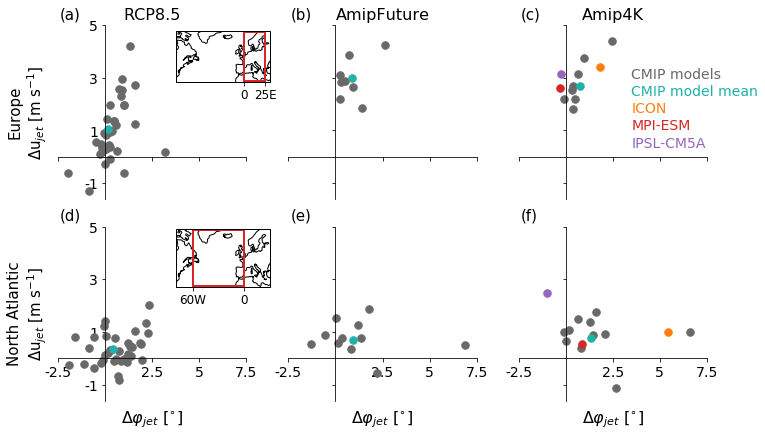

In [10]:
color_cmip = 'dimgrey'
color_mean = 'lightseagreen'
color_icon = 'tab:orange'
color_mpi = 'tab:red'
color_ipsl = 'tab:purple'
ms = 7.5  # markersize
ylab = ['Europe', 'North Atlantic']

fig, ax = plt.subplots(len(box_west), 3, figsize=(10, 6))
for b in range(len(box_west)):
    # coupled models
    ax[b, 0].plot(djetlat_cmip_box[b, :], djetint_cmip_box[b, :],
                  linestyle='none', marker='o', color=color_cmip, 
                  markersize=ms)
    ax[b, 0].plot(djetlat_cmip_mm_box[b], djetint_cmip_mm_box[b],
                  linestyle='none', marker='o', color=color_mean,
                  markersize=ms)
    # amip models
    # amipFuture
    ax[b, 1].plot(djetlat_amipfut_box[b, :], djetint_amipfut_box[b, :],
                  linestyle='none', marker='o', color=color_cmip, 
                  markersize=ms)
    ax[b, 1].plot(djetlat_amipfut_mm_box[b], djetint_amipfut_mm_box[b],
                  linestyle='none', marker='o', color=color_mean,
                  markersize=ms)
    # amip4K
    ax[b, 2].plot(djetlat_amip4k_box[b, :], djetint_amip4k_box[b, :],
                  linestyle='none', marker='o', color=color_cmip, 
                  markersize=ms)
    ax[b, 2].plot(djetlat_amip4k_mm_box[b], djetint_amip4k_mm_box[b],
                  linestyle='none', marker='o', color=color_mean,
                  markersize=ms)
    # ICON, MPI-ESM, IPSL-CM5A
    ax[b, 2].plot(djetlat_icon_box[b], djetint_icon_box[b],
                  linestyle='none', marker='o', color=color_icon,
                  markersize=ms)
    ax[b, 2].plot(djetlat_mpi_box[b], djetint_mpi_box[b],
                  linestyle='none', marker='o', color=color_mpi,
                  markersize=ms)
    ax[b, 2].plot(djetlat_ipsl_box[b], djetint_ipsl_box[b],
                  linestyle='none', marker='o', color=color_ipsl,
                  markersize=ms)
    
    # ylabel
    ax[b, 0].set_ylabel(ylab[b] + '\n$\Delta$u$_{jet}$ [m s$^{-1}$]', fontsize=15)
    ax[b, 0].yaxis.set_label_coords(-0.05, 0.5)
del b
ax[0, 0].set_title('RCP8.5', fontsize=16)
ax[0, 1].set_title('AmipFuture', fontsize=16)
ax[0, 2].set_title('Amip4K', fontsize=16)

fig.canvas.draw()
fig.tight_layout()

# plot maps for Europe and North Atlantic as small inserted plot
# Europe
inset_ax = inset_axes(ax[0, 0], 
                      width="50%",
                      height="50%",
                      #loc="upper right",
                      bbox_to_anchor=(0.15, 0.1, 1, 1),
                      bbox_transform=ax[0, 0].transAxes,
                      axes_class=cartopy.mpl.geoaxes.GeoAxes,
                      axes_kwargs=dict(map_projection=ccrs.PlateCarree(central_longitude=-90.)))
inset_ax.coastlines()
inset_ax.set_aspect(1.5)
inset_ax.tick_params(labelsize=12)
# extended North Atlantic region
inset_ax.set_extent([-80, 30, 30, 70], ccrs.PlateCarree())
# set xticks and yticks for latitudes and longitudes
# xaxis: longitudes
inset_ax.set_xticks([0, 25], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                   degree_symbol='',
                                   dateline_direction_label=True)
inset_ax.xaxis.set_major_formatter(lon_formatter)
del lon_formatter

# mark west and east boundaries of Europe
lonwest = 0; loneast = 25; latsout=30.8; latnort=69.2
# left vertical line
inset_ax.plot([lonwest, lonwest], [latsout, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# right vertical line
inset_ax.plot([loneast, loneast], [latsout, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# upper horizontal line
inset_ax.plot([loneast, lonwest], [latnort, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# lower horizontal line
inset_ax.plot([lonwest, loneast], [latsout, latsout],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
del inset_ax

# North Atlantic
inset_ax = inset_axes(ax[1, 0], 
                      width="50%",
                      height="50%",
                      #loc="upper right",
                      bbox_to_anchor=(0.15, 0.1, 1, 1),
                      bbox_transform=ax[1, 0].transAxes,
                      axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                      axes_kwargs=dict(map_projection=ccrs.PlateCarree(central_longitude=-90.)))
inset_ax.coastlines()
inset_ax.set_aspect(1.7)
inset_ax.tick_params(labelsize=12)
# extended North Atlantic region
inset_ax.set_extent([-80, 30, 30, 70], ccrs.PlateCarree())
# set xticks and yticks for latitudes and longitudes
# xaxis: longitudes
inset_ax.set_xticks([-60, 0], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                   degree_symbol='',
                                   dateline_direction_label=True)
inset_ax.xaxis.set_major_formatter(lon_formatter)
del lon_formatter

# mark west and east boundaries of Europe
lonwest = -60; loneast = 0; latsout=30.8; latnort=69.2
# left vertical line
inset_ax.plot([lonwest, lonwest], [latsout, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# right vertical line
inset_ax.plot([loneast, loneast], [latsout, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# upper horizontal line
inset_ax.plot([loneast, lonwest], [latnort, latnort],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
# lower horizontal line
inset_ax.plot([lonwest, loneast], [latsout, latsout],
              linewidth=2, color='tab:red', transform=ccrs.PlateCarree())
del inset_ax

ax = ax.reshape(-1)
for i in range(ax.shape[0]):
    ax[i].tick_params(labelsize=14)
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['left'].set_position('zero')
    ax[i].spines['bottom'].set_position('zero')
    # x-ticks
    ax[i].xaxis.set_ticks([-5, -2.5, 2.5, 5, 7.5, 10])#, 15])
    ax[i].xaxis.set_ticklabels([-5, -2.5, 2.5, 5, 7.5, 10])#, 15])
    ax[i].set_xlim(-2.5, 7.5)#7)
    # y-ticks
    ax[i].yaxis.set_ticks([-1, 1, 3, 5])
    ax[i].yaxis.set_ticklabels([-1, 1, 3, 5])
    ax[i].set_ylim(-1.6, 5)
    # labels
    ax[i].set_xlabel(r'$\Delta \varphi_{jet}$ [$^{\circ}$]', fontsize=16)
    ax[i].xaxis.set_label_coords(0.5, -0.05)
    # hide x labels and tick labels for top plots and y ticks for right plots.
    ax[i].label_outer()
del i

# text for colors
fig.text(0.88, 0.82, 'CMIP models', color=color_cmip, ha='left',
         va='center', fontsize=14)
fig.text(0.88, 0.78, 'CMIP model mean', color=color_mean, ha='left',
         va='center', fontsize=14)
fig.text(0.88, 0.74, 'ICON', color=color_icon, ha='left',
         va='center', fontsize=14)
fig.text(0.88, 0.70, 'MPI-ESM', color=color_mpi, ha='left',
         va='center', fontsize=14)
fig.text(0.88, 0.66, 'IPSL-CM5A', color=color_ipsl, ha='left',
         va='center', fontsize=14)

# a), b) etc for subplots
labs = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i in range(ax.shape[0]):
    ax[i].text(0.01, 1.02, labs[i], va='bottom', ha='left',
               rotation_mode='anchor', fontsize=15,
               transform=ax[i].transAxes)
del i

fig.savefig('figure2a_2f.pdf', bbox_inches='tight')

plt.show(fig)
plt.close(fig)
del fig, ax

del color_cmip, color_mean, color_icon
del color_mpi, color_ipsl, ms
del ylab